# photometry_plot2.ipynb

開口測光したデータをプロットする。横軸は衛星のSys3経度。

In [165]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patheffects as pe
import pandas as pd
import os
import copy
import ftpS3
import localtime
import spiceypy as spice
spice.furnsh('kernel/cassMetaK.txt')

fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                    'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold'
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

# cpalette = ['#8ecae6', '#ffb703', '#023047', '#fb8500', '#219ebc']
cpalette = ['#0F4C81', '#FF6F61', '#645394',
         '#84BD00', '#F6BE00', '#F7CAC9', '#0F80E6']
cpalette = ['#184678', '#005261', '#C00000', '#E88B00', '#F25A00', '#2F397D', '#A3BDDA', '#9FC0B4', '#F3B5A8', '#EECA77', '#EFA785', '#AAACD4']
cpalette = ['#E7534B', '#EF8C46', '#F7D702', '#3C8867', '#649CDB', '#5341A5', '#A65FAC', '#A2AAAD']

# Color universal design
cud4 = ['#FF3300', '#FFF100', '#03AF7A', '#005AFF', '#4DC4FF', '#FF8082', '#F6AA00', '#990099', '#804000']
cud4bs = ['#FFCABF', '#FFFF80', '#D8F255', '#BFE4FF', '#FFCA80', '#77D9A8', '#C9ACE6', '#84919E']

In [166]:
# Set legend shadow
def legend_shadow(fig, ax, legend, dx, dy):

  frame = legend.get_window_extent()

  xmin, ymin = fig.transFigure.inverted().transform((frame.xmin, frame.ymin))
  xmax, ymax = fig.transFigure.inverted().transform((frame.xmax, frame.ymax))

  # plot patch shadow
  rect = patches.Rectangle((xmin+dx, ymin+dy), xmax-xmin, ymax-ymin, 
                          transform=fig.transFigure,
                          edgecolor='k', facecolor='k',
                          clip_on=False)
  ax.add_patch(rect)

  return None

In [167]:
north_doy = ['14/006_v06', '14/013_v13', '14/016_v12', '22/271_v18', '22/274_v17']
south_doy = ['22/185_v09', '22/310_v19', '22/349_v23']
# south_doy = ['22/185_v09', '22/185_v09_MAW']

nbkg_doy = ['14/001_v01', '14/002_v02', '14/005_v05', '14/006_v06', '14/013_v13', '14/016_v12', '22/185_v10', '22/228_v13', '22/271_v18', '22/274_v17', '22/309_v20', '22/349_v24']
sbkg_doy = ['22/140_v03', '22/185_v09', '22/186_v11', '22/229_v14', '22/310_v19', '22/311_v21', '22/349_v23']

def load(csvname0):
    df = pd.read_csv(csvname0, sep='\t')
    utc = df.loc[:, 'date']                                 # UTC date
    efplat = df.loc[:, 'lat [deg]'].values                  # EFP latitude [deg]
    efpwlong = df.loc[:, 'wlong [deg]'].values              # EFP System III longitude [deg]
    moons3 = df.loc[:, 'Moon S3 [deg]'].values              # Europa's System III longitude [deg]
    final_phot_ave = df.loc[:, 'spot brightness [kR]']      # EFP brightness [kR]
    annulus_median = df.loc[:, 'local background [kR]']     # local background [kR]
    
    b0_arr = np.zeros(len(final_phot_ave))
    b1_arr = np.zeros(len(final_phot_ave))
    efplat0_arr = np.zeros(len(final_phot_ave))
    efpwlong0_arr = np.zeros(len(final_phot_ave))
    moons30_arr = np.zeros(len(final_phot_ave))
    for i in range(len(final_phot_ave)):
        if final_phot_ave[i] != '0':
            b0_arr[i] = final_phot_ave[i]
            b1_arr[i] = annulus_median[i]
            efplat0_arr[i] = efplat[i]
            efpwlong0_arr[i] = efpwlong[i]
            moons30_arr[i] = moons3[i]
        else:
            continue
    
    return utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr

JRM33計算結果

磁気赤道面crossingのSys3 [deg] 110.61452513966482

磁場成分 Br 最大のSys3 [deg] 189.05027932960894

磁気赤道面crossingのSys3 [deg] 281.56424581005587

### 北半球 発光強度 (横軸: EuropaのS3経度)

In [168]:
hem = 'North'
if hem == 'North':
    doy = north_doy
    bkgdoy = nbkg_doy
    bon17 = '0006'
elif hem == 'South':
    doy = south_doy
    bkgdoy = sbkg_doy
    bon17 = '0007'
else:
    doy = north_doy+south_doy
    bkgdoy = nbkg_doy+sbkg_doy

refnum = 0
if hem == 'South':
    refnum = 1
satoval = np.recfromtxt('ref/2021je007055-sup-000'+str(3+refnum)+'-table si-s0'+str(2+refnum)+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

xing_s3wlon_110 = ftpS3.ftpS3().FPW(110.61452513966482, satoval, 'EUROPA')
xing_s3wlon_290 = ftpS3.ftpS3().FPW(110.61452513966482+180, satoval, 'EUROPA')

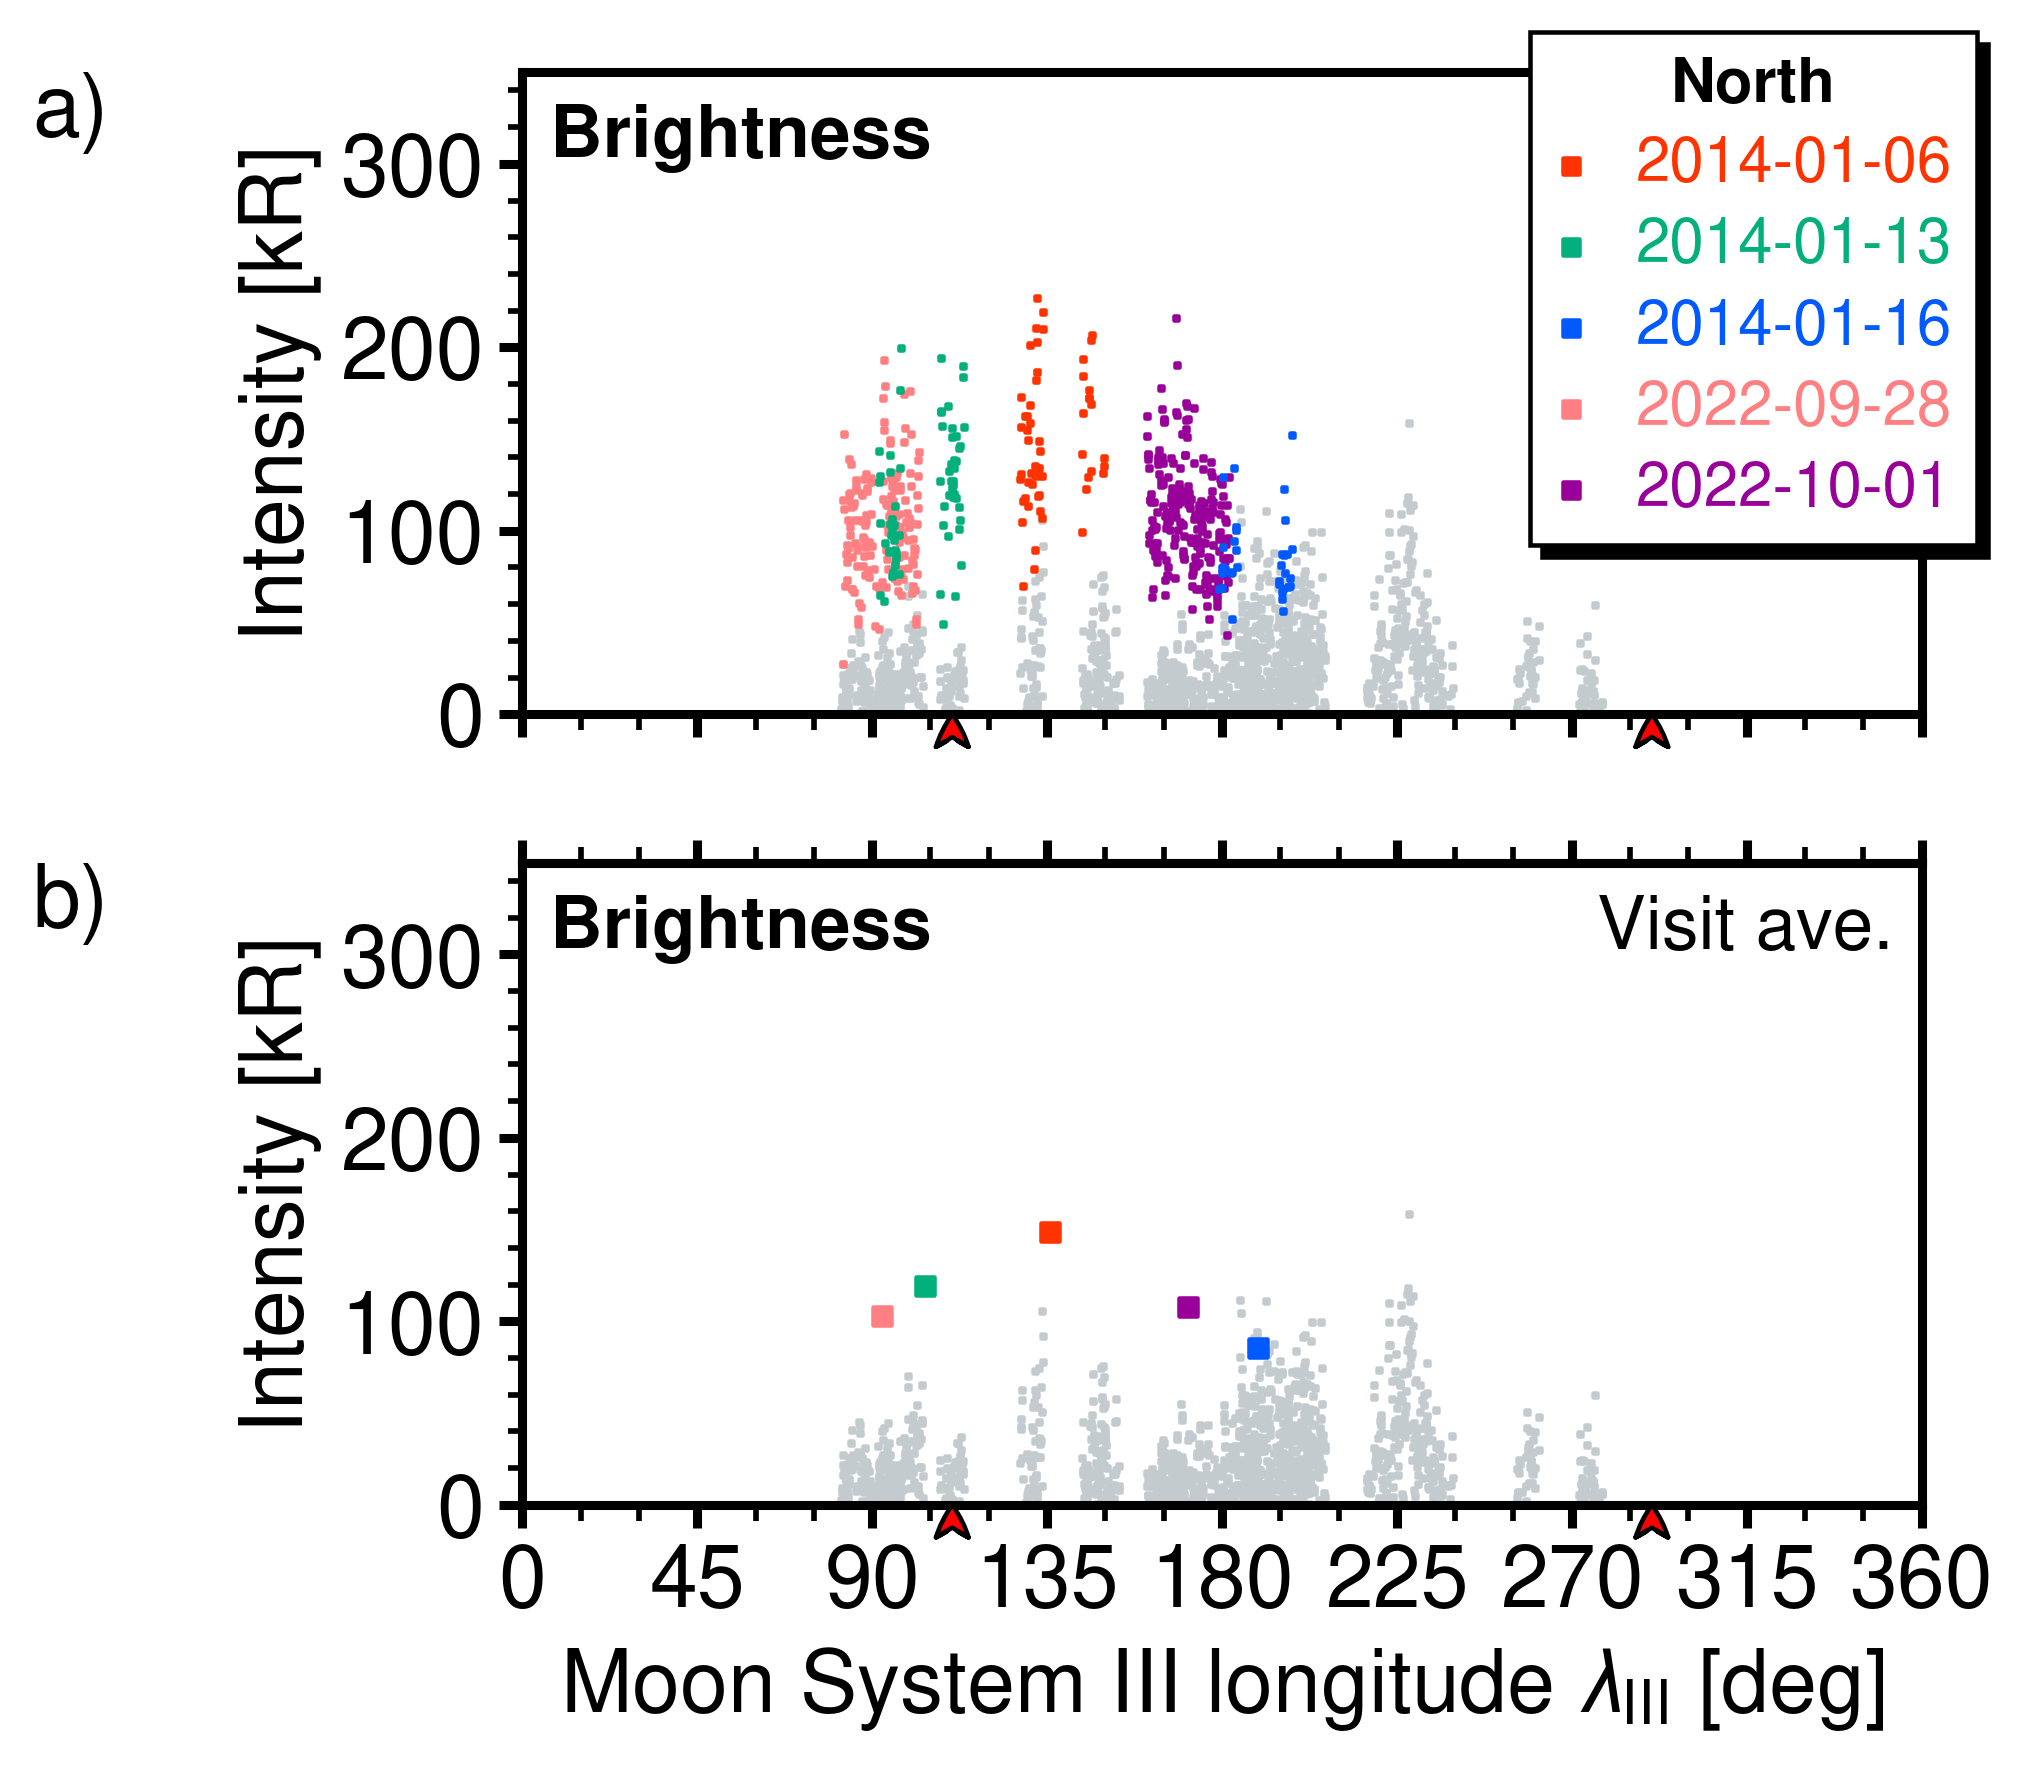

In [169]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(5,5), dpi=326)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].set_ylim(0,350)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].set_yticks(np.linspace(0,300,4,dtype=int))
    ax[i].set_yticklabels(np.linspace(0,300,4,dtype=int))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
    ax[i].set_ylabel('Intensity [kR]', fontsize=fontsize)
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].text(0.02, 0.95, 'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
doyname =['2014-01-06', '2014-01-13', '2014-01-16']+['2022-09-28', '2022-10-01']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c=cud4_N[i], label=doyname[i], zorder=10-i)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)

legend_fsize = fontsize*0.72
legend1 = ax[0].legend(loc='upper center',
                    ncol=1,
                    markerscale=3.5,
                    bbox_to_anchor=(0.88, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=0.5,
                    scatterpoints=1, )
legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_N[i])
    i += 1


# ===========
# SECOND PLOT
# ===========
ax[1].text(0.02, 0.95, 'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
ax[1].text(0.98, 0.95, 'Visit ave.', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(moons30_ave, b0_ave, marker=',', s=15.0, c=cud4_N[i], label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    
plt.show()

### 南半球 発光強度 (横軸: EuropaのS3経度)

In [170]:
hem = 'South'
if hem == 'North':
    doy = north_doy
    bkgdoy = nbkg_doy
    bon17 = '0006'
elif hem == 'South':
    doy = south_doy
    bkgdoy = sbkg_doy
    bon17 = '0007'
else:
    doy = north_doy+south_doy
    bkgdoy = nbkg_doy+sbkg_doy

refnum = 0
if hem == 'South':
    refnum = 1
satoval = np.recfromtxt('ref/2021je007055-sup-000'+str(3+refnum)+'-table si-s0'+str(2+refnum)+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

xing_s3wlon_110 = ftpS3.ftpS3().FPW(110.61452513966482, satoval, 'EUROPA')
xing_s3wlon_290 = ftpS3.ftpS3().FPW(110.61452513966482+180, satoval, 'EUROPA')

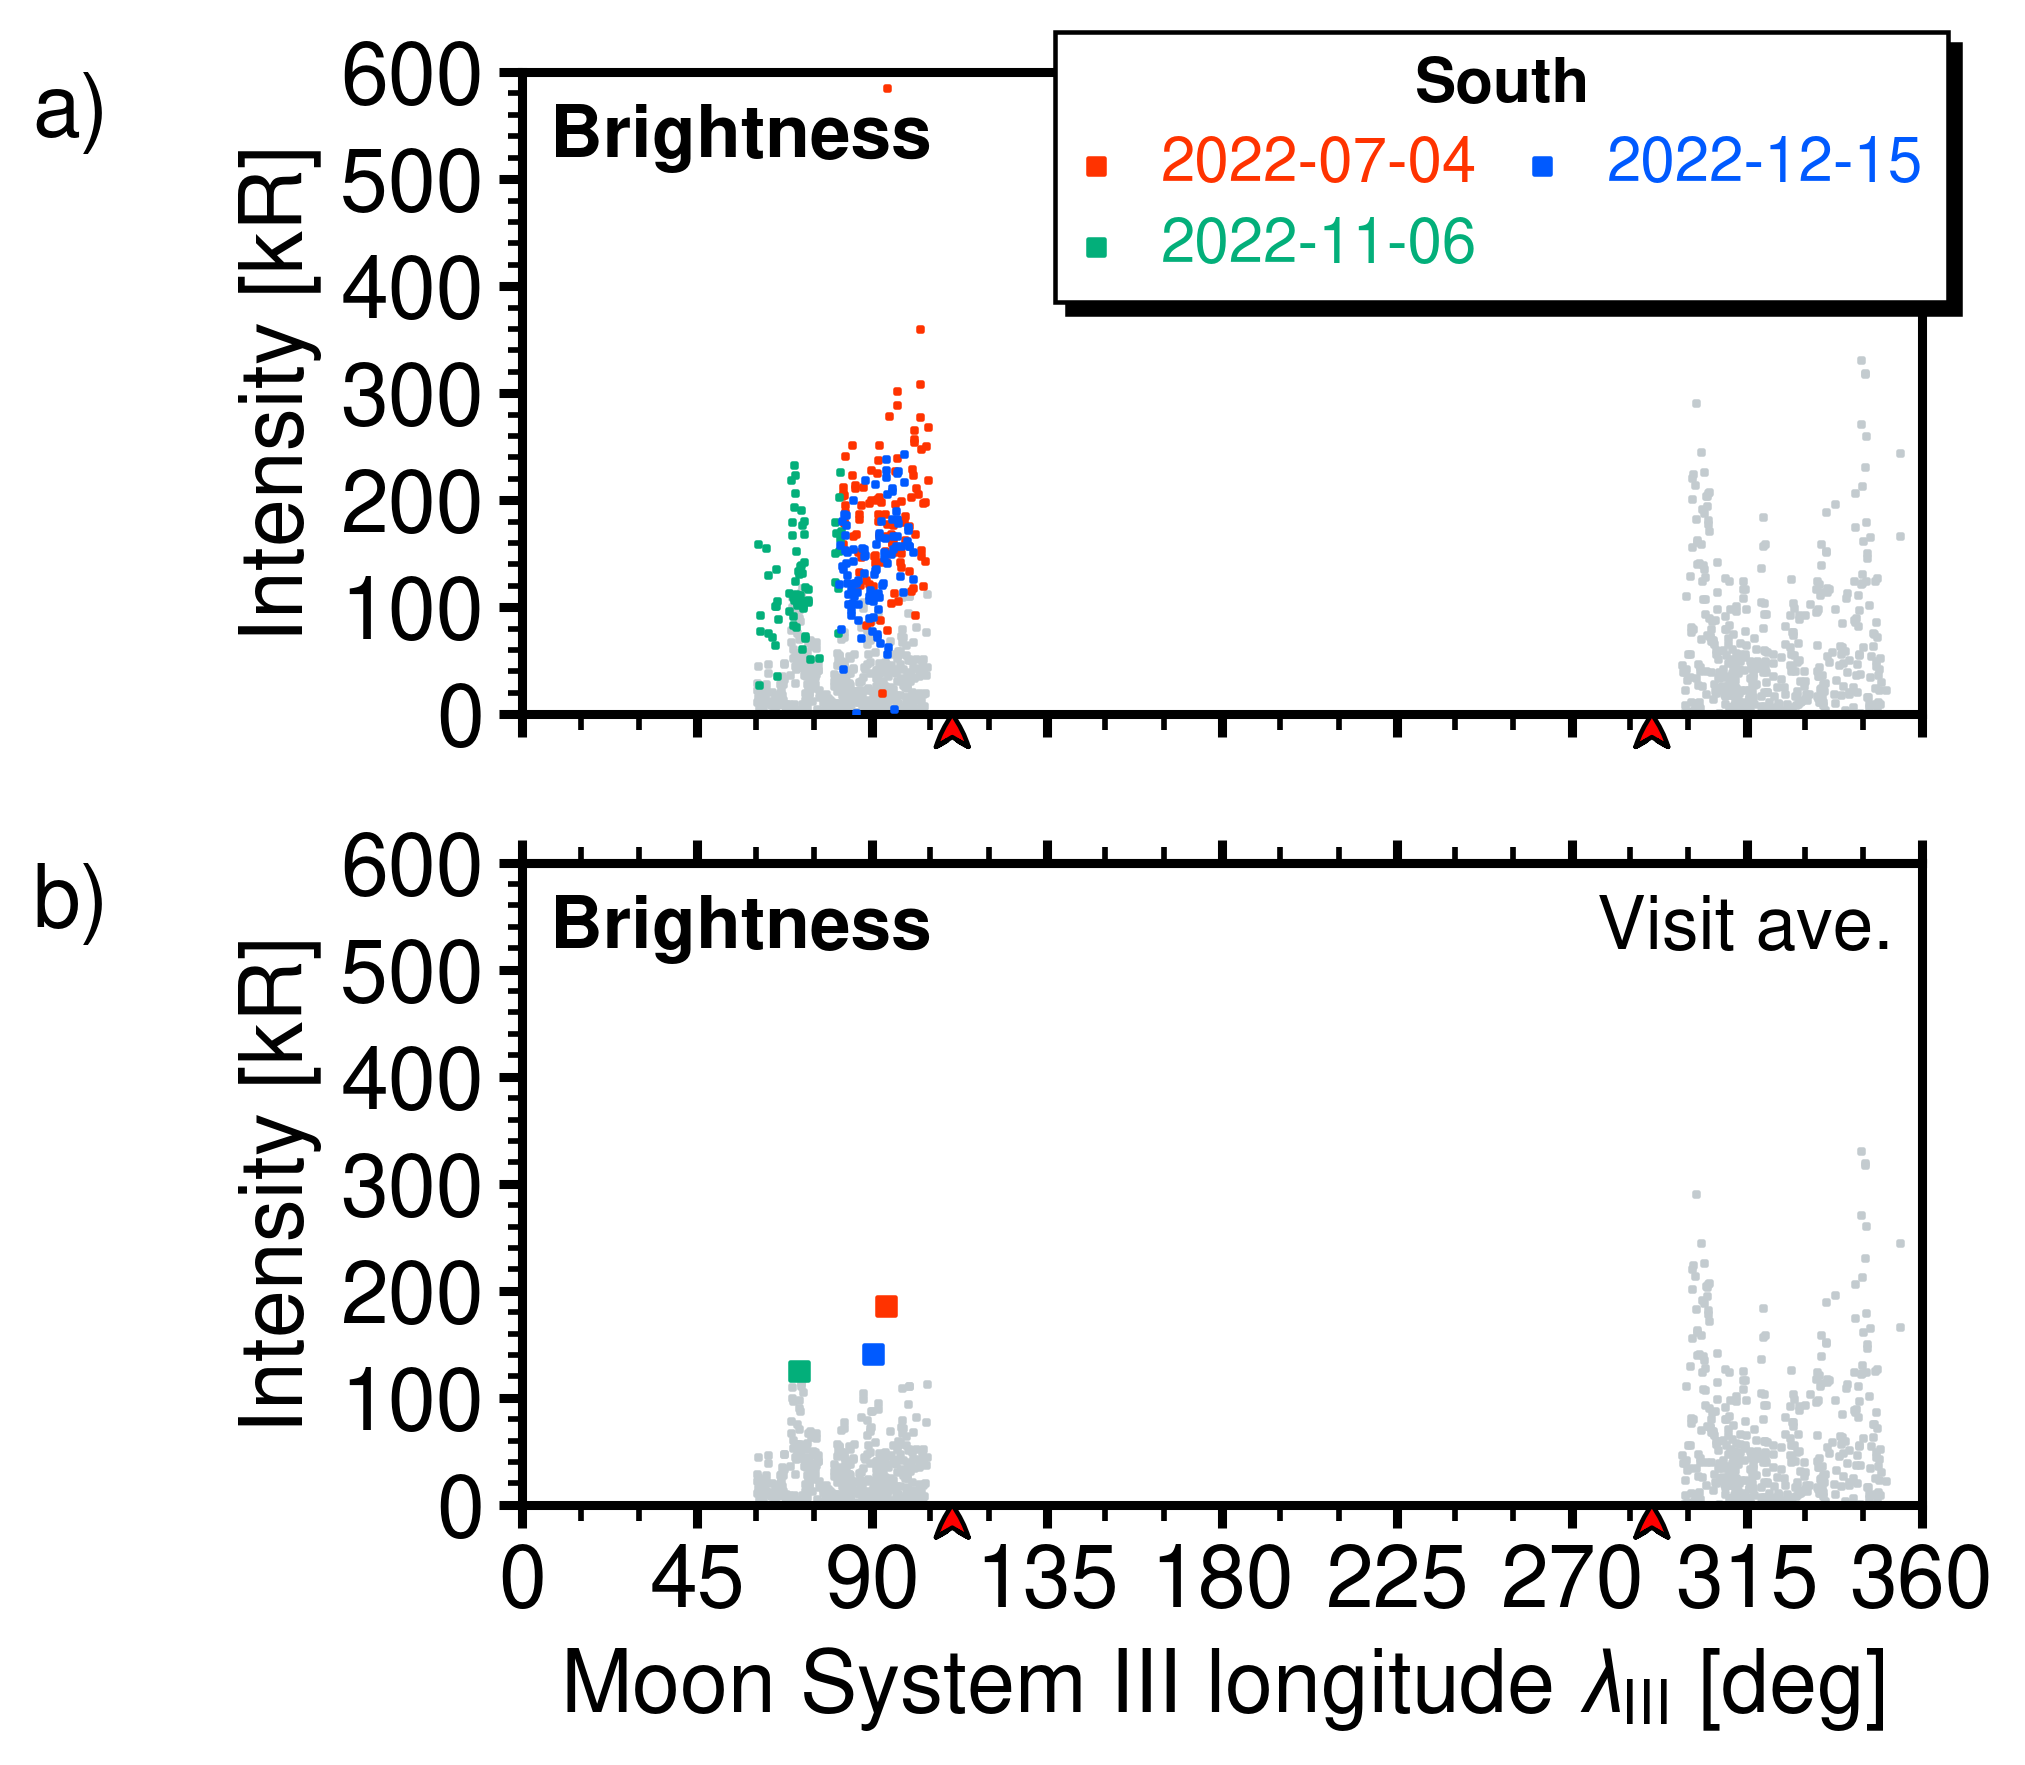

In [171]:
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(5,5), dpi=326)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].set_ylim(0, 600)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].set_yticks(np.arange(0,601,100,dtype=int))
    ax[i].set_yticklabels(np.arange(0,601,100,dtype=int))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
    ax[i].set_ylabel('Intensity [kR]', fontsize=fontsize)
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].text(0.02, 0.95, 'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5]]
doyname = ['2022-07-04', '2022-11-06', '2022-12-15']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c=cud4_N[i], label=doyname[i], zorder=1+i)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)

legend_fsize = fontsize*0.72
legend1 = ax[0].legend(loc='upper center',
                    ncol=2,
                    markerscale=3.5,
                    bbox_to_anchor=(0.70, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    columnspacing=0.8,
                    handlelength=0.5,
                    scatterpoints=1, )
legend1.set_title('South', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_N[i])
    i += 1


# ===========
# SECOND PLOT
# ===========
ax[1].text(0.02, 0.95, 'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
ax[1].text(0.98, 0.95, 'Visit ave.', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(moons30_ave, b0_ave, marker=',', s=15.0, c=cud4_N[i], label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    
plt.show()